## Building Project with Agent

In [3]:
!pip install langgraph langchain langchain-community langchain-openai python-dotenv langgraph-checkpoint-sqlite tavily-python langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.3 MB/s eta 0:00:00


In [2]:
import os
import operator
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from IPython.display import Image, Markdown
from dotenv import load_dotenv

# load the .env file
load_dotenv('.env')

TAVILY_API_KEY = os.environ['TAVILY_API_KEY']
TOGETHER_API_KEY = os.environ['TOGETHER_API_KEY']

In [5]:
# To allow agent to have multi-turn conversations.
# LangGraph provides persistent checkpointing. If
# we provide checkpointer when compiling the graph and thread_id
# when calling the graph, LangGraph automatically saves the state
# after each step. When you invoke the graph again using the same
# thread_id, the graph loads its saved state, allowing the agent
# to pick up where it left off.

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

model = ChatOpenAI(base_url="https://api.together.xyz/v1",
    temperature=0,
    api_key=TOGETHER_API_KEY,
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo")

tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [14]:
PLAN_PROMPT = """
You are an expert essay writer and planner. Your task is to create a detailed, high-level outline for an essay based on the topic provided by the user.

- Begin by briefly identifying the core idea or thesis of the essay.
- Then, generate a structured outline with clear section headings (e.g., Introduction, Body Paragraphs, Conclusion), each with bullet points or sub-sections indicating the main ideas or arguments to be covered.
- Include relevant notes, tips, or stylistic suggestions for each section to guide the writing process (e.g., tone, examples to include, logical flow, citations if applicable).

The goal is to provide a solid scaffold that helps the user write a coherent, well-argued, and engaging essay on the given topic.
"""

RESEARCH_PLAN_PROMPT = """
You are an experienced researcher supporting the writing of an essay on the topic provided below.

Your task is to generate up to **three well-crafted search queries** that will help gather the most relevant, credible, and useful information for writing the essay.

The queries should aim to uncover key facts, arguments, statistics, historical context, expert opinions, or recent developments related to the topic.
"""

WRITER_PROMPT = """
You are a skilled essay writing assistant. Your task is to write a clear, coherent, and engaging 5-paragraph essay based on the user's request and the initial outline.

- Follow the classic 5-paragraph structure: Introduction, 3 Body Paragraphs, and Conclusion.
- Ensure logical flow, strong transitions, and well-supported arguments.
- Maintain appropriate tone and style depending on the topic (e.g., academic, persuasive, reflective).
- Use the provided content below as your guide. If this is a revision request, improve upon the previous essay based on the critique given.

----------

{content}
"""

REFLECTION_PROMPT = """
You are an experienced teacher reviewing a student's essay submission.

Your task is to provide constructive, detailed feedback and actionable recommendations for improvement.
Consider the essay’s structure, clarity, argumentation, depth of analysis, grammar, style, and adherence to the prompt.

Your feedback should include:
- Strengths of the submission
- Areas for improvement
- Specific suggestions for enhancing length, depth, clarity, or style
- Tone and voice appropriateness
- Any missing elements or ideas that could strengthen the essay

Be encouraging but honest, and aim to help the student produce a significantly improved next draft.
"""

RESEARCH_CRITIQUE_PROMPT = """
You are a researcher supporting revisions to an essay based on the critique provided below.

Your task is to generate up to **three targeted search queries** that will help the writer gather additional or improved information needed for revision.
These queries should aim to address specific weaknesses, gaps, or improvement areas identified in the feedback — such as lack of depth, missing examples, unclear arguments, or insufficient evidence.

Focus on crafting precise, high-impact queries that directly support a stronger revised draft.
"""

In [11]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [12]:
class Queries(BaseModel):
    queries: List[str]

In [15]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [16]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q,
                                 max_results=2,
                                 search_depth='advanced',
                                 max_tokens=1000)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [17]:
def generation_node(state: AgentState):
    content = "\n\n".join(["content"] or [])
    user_message = HumanMessage(content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [18]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft']),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [19]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q,
                                 max_results=2,
                                 search_depth='advanced',
                                 max_tokens=1000)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [20]:
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

In [21]:
builder = StateGraph(AgentState)

In [ ]:
builder.add_node('planner', plan_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_critique', research_critique_node)

builder.set_entry_point('planner')

In [25]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [26]:
# compile the graph
graph = builder.compile(checkpointer=memory)

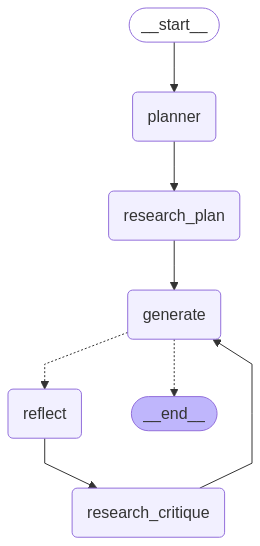

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
results = []

thread = {
    "configurable": {'thread_id': '1'}
}
for s in graph.stream({
    'task': 'Write essay on the Harry Potter Novels',
    'max_revisions': 2,
    'revision_number': 1
}, thread):
    results.append(s)
    print(s)

{'planner': {'plan': "**Core Idea/Thesis:**\nThe Harry Potter novels by J.K. Rowling are a masterpiece of modern literature that not only captivated the hearts of millions of readers worldwide but also provided a rich tapestry of themes, characters, and symbolism that continue to resonate with readers of all ages. Through the series, Rowling explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil, ultimately creating a world that is both magical and profoundly relatable.\n\n**Essay Outline:**\n\n**I. Introduction**\n\n* Briefly introduce the Harry Potter series and its author, J.K. Rowling\n* Provide background information on the series' popularity and impact\n* Thesis statement: The Harry Potter novels are a masterpiece of modern literature that explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil.\n\n**Notes:**\n\n* Use a hook to grab the reader's attention, e.g.

### Planner

In [29]:
Markdown(results[0]["planner"]["plan"])

**Core Idea/Thesis:**
The Harry Potter novels by J.K. Rowling are a masterpiece of modern literature that not only captivated the hearts of millions of readers worldwide but also provided a rich tapestry of themes, characters, and symbolism that continue to resonate with readers of all ages. Through the series, Rowling explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil, ultimately creating a world that is both magical and profoundly relatable.

**Essay Outline:**

**I. Introduction**

* Briefly introduce the Harry Potter series and its author, J.K. Rowling
* Provide background information on the series' popularity and impact
* Thesis statement: The Harry Potter novels are a masterpiece of modern literature that explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil.

**Notes:**

* Use a hook to grab the reader's attention, e.g., a quote from the series or a fascinating fact about the author
* Keep the introduction concise and focused on the main argument
* Use a clear and concise writing style throughout the essay

**II. The Power of Love and Friendship**

* Discuss the importance of relationships in the series, particularly the bond between Harry, Ron, and Hermione
* Analyze how these relationships help the characters overcome challenges and grow as individuals
* Explore the symbolism of love and friendship in the series, e.g., the importance of loyalty, trust, and sacrifice

**Examples to include:**

* The friendship between Harry, Ron, and Hermione in the first book
* The sacrifice of Sirius Black and the impact on Harry's relationships
* The love story between Ron and Hermione and its significance in the series

**III. The Struggle between Good and Evil**

* Discuss the main antagonists in the series, e.g., Voldemort, Draco Malfoy, and the Death Eaters
* Analyze how the characters grapple with the nature of good and evil, e.g., Harry's struggle with his destiny and the temptation of power
* Explore the symbolism of good and evil in the series, e.g., the importance of morality, courage, and redemption

**Examples to include:**

* The backstory of Voldemort and his descent into darkness
* The character development of Severus Snape and his ultimate redemption
* The significance of the Horcruxes and the ultimate defeat of Voldemort

**IV. The Complexity of Human Nature**

* Discuss the complexities of the main characters, e.g., Harry's insecurities, Ron's jealousy, and Hermione's perfectionism
* Analyze how the series explores the human condition, e.g., fear, anger, and the struggle for identity
* Explore the symbolism of human nature in the series, e.g., the importance of self-discovery, growth, and transformation

**Examples to include:**

* The character development of Luna Lovegood and her unique perspective on the world
* The exploration of mental health and trauma in the series, e.g., Harry's PTSD and Ginny's anxiety
* The significance of the wizarding world's treatment of non-human magical creatures and the impact on the characters

**V. Conclusion**

* Summarize the main arguments and themes of the essay
* Reiterate the thesis statement and provide supporting evidence from the series
* Final thoughts: the enduring impact of the Harry Potter series and its continued relevance in modern society

**Notes:**

* Use a clear and concise writing style throughout the conclusion
* Avoid introducing new information or arguments in the conclusion
* End with a thought-provoking statement or a call to action

### Research Plan

In [30]:
for content in results[1]["research_plan"]["content"]:
    print(content)
    print('------')

The findings showed that J. K. Rowling mostly used compound complex, declarative, simple past, and active voice. The transformed sentences were mostly composed
------
possesses a talent for creating complex and fallible characters who make her books comparable to those of other literary greats. Rowling's use of complicated characters and literary devices not only set her apart from many of her contemporaries, but also places her among a canon of great authors who use these same techniques to make their works more literary. On the surface, Rowling's series may appear to serve a purely entertaining purpose, but Rowling has created a layered narrative that [...] story more satirical. Rowling takes the commonly recognized stereotype of competitive academics and exaggerates it, making her characters so competitive that it is sometimes laughable. For example, in Book Two, 39 Chamber of Secrets, Snape embarrasses Professor Lockhart, a man known for his inflated ego and boastful exaggerations,

### Generate Draft

In [31]:
Markdown(results[2]["generate"]["draft"])

**The Enchanted World of Harry Potter: A Masterpiece of Modern Literature**

J.K. Rowling's Harry Potter series has captivated the hearts of millions of readers worldwide, transporting them to a magical world of wonder and awe. As the most beloved and enduring series of the 21st century, Harry Potter has not only become a cultural phenomenon but also a rich tapestry of themes, characters, and symbolism that continue to resonate with readers of all ages. Through the series, Rowling explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil, ultimately creating a world that is both magical and profoundly relatable.

**The Power of Love and Friendship**

At the heart of the Harry Potter series lies the importance of relationships, particularly the bond between Harry, Ron, and Hermione. Their friendship is a testament to the power of love and loyalty, as they support and encourage each other through thick and thin. The series highlights the significance of trust, sacrifice, and loyalty, as the trio faces numerous challenges and overcomes incredible odds. The sacrifice of Sirius Black, for instance, has a profound impact on Harry's relationships, teaching him the value of love and the importance of holding onto those who care for him. The love story between Ron and Hermione, on the other hand, adds a new dimension to the series, showcasing the complexities of romantic relationships and the power of love to overcome even the most daunting challenges.

**The Struggle between Good and Evil**

The Harry Potter series is a classic tale of good vs. evil, with Voldemort and his Death Eaters representing the darkest aspects of human nature. The series explores the complexities of morality, courage, and redemption, as the characters grapple with the nature of good and evil. Harry's struggle with his destiny and the temptation of power is a prime example of this, as he navigates the weight of his responsibilities and the danger of succumbing to the Dark Lord's influence. The character development of Severus Snape, who ultimately redeems himself through his love for Lily and his protection of Harry, is a powerful exploration of the human capacity for growth and transformation. The significance of the Horcruxes, on the other hand, serves as a reminder of the devastating consequences of evil and the importance of confronting and defeating it.

**The Complexity of Human Nature**

The Harry Potter series is a rich exploration of the human condition, delving into the complexities of fear, anger, and the struggle for identity. The characters are multidimensional and relatable, with their own unique struggles and insecurities. Harry's insecurities, Ron's jealousy, and Hermione's perfectionism are just a few examples of the many complexities that make up the human experience. The series also explores the importance of self-discovery, growth, and transformation, as the characters navigate the challenges of adolescence and young adulthood. The character development of Luna Lovegood, who offers a unique perspective on the world, is a prime example of this, as she encourages the reader to think outside the box and challenge their assumptions.

**Conclusion**

The Harry Potter series is a masterpiece of modern literature that continues to captivate readers of all ages. Through its exploration of the complexities of human nature, the power of love and friendship, and the struggle between good and evil, the series creates a world that is both magical and profoundly relatable. As we reflect on the enduring impact of the series, we are reminded of the importance of love, loyalty, and the human capacity for growth and transformation. The Harry Potter series is a testament to the power of storytelling and the enduring relevance of its themes in modern society. As we continue to navigate the complexities of our own world, the lessons of Harry Potter remain a powerful reminder of the importance of empathy, compassion, and the human spirit.

### Reflect critique for Draft

In [32]:
Markdown(results[3]["reflect"]["critique"])

**Overall Assessment**

Your essay provides a comprehensive and engaging analysis of the Harry Potter series, exploring its themes, characters, and symbolism. You have successfully demonstrated a deep understanding of the series and its impact on readers worldwide. Your writing is clear, concise, and well-organized, making it easy to follow and understand.

**Strengths**

1. **Clear Structure**: Your essay follows a logical structure, with each section exploring a specific theme or aspect of the series.
2. **Engaging Writing Style**: Your writing is engaging, and you have used vivid language to describe the series and its characters.
3. **Depth of Analysis**: You have provided a thorough analysis of the series, exploring its themes, characters, and symbolism in depth.
4. **Use of Examples**: You have effectively used examples from the series to support your arguments, making your analysis more convincing and relatable.

**Areas for Improvement**

1. **Transitions and Connections**: While your essay is well-structured, there are moments where the transitions between sections feel a bit abrupt. Consider adding more transitional phrases or sentences to connect your ideas more smoothly.
2. **Depth of Analysis in Some Sections**: While your analysis is thorough in some sections, it feels a bit superficial in others. Consider delving deeper into the themes and characters, exploring their complexities and nuances.
3. **Use of Quotes and Evidence**: While you have used examples from the series, consider incorporating more quotes and evidence to support your arguments. This will add more depth and credibility to your analysis.
4. **Conclusion**: While your conclusion is a good summary of your main points, it feels a bit repetitive. Consider adding more depth and analysis to your conclusion, exploring the broader implications of the series and its themes.

**Specific Suggestions**

1. **Use more nuanced language**: While your writing is clear and concise, consider using more nuanced language to describe the series and its themes. This will add more depth and complexity to your analysis.
2. **Explore the series' cultural significance**: Consider exploring the series' cultural significance, discussing how it reflects and shapes societal attitudes towards love, friendship, and good vs. evil.
3. **Analyze the series' use of symbolism**: Consider analyzing the series' use of symbolism, exploring how it adds depth and complexity to the narrative.
4. **Discuss the series' impact on readers**: Consider discussing the series' impact on readers, exploring how it has influenced their perspectives on love, friendship, and good vs. evil.

**Tone and Voice**

Your tone and voice are engaging and enthusiastic, reflecting your passion for the series. However, consider toning down your language in some sections, as it feels a bit too effusive at times. A more measured tone will add more credibility to your analysis.

**Missing Elements**

1. **More nuanced analysis of the series' themes**: While your analysis is thorough, consider exploring the series' themes in more depth, exploring their complexities and nuances.
2. **More discussion of the series' cultural significance**: Consider discussing the series' cultural significance, exploring how it reflects and shapes societal attitudes towards love, friendship, and good vs. evil.
3. **More analysis of the series' use of symbolism**: Consider analyzing the series' use of symbolism, exploring how it adds depth and complexity to the narrative.

Overall, your essay provides a comprehensive and engaging analysis of the Harry Potter series. With some revisions to address the areas for improvement, it has the potential to be a truly outstanding essay.

In [33]:
for content in results[4]["research_critique"]["content"]:
    print(content)
    print("---------")

The findings showed that J. K. Rowling mostly used compound complex, declarative, simple past, and active voice. The transformed sentences were mostly composed
---------
possesses a talent for creating complex and fallible characters who make her books comparable to those of other literary greats. Rowling's use of complicated characters and literary devices not only set her apart from many of her contemporaries, but also places her among a canon of great authors who use these same techniques to make their works more literary. On the surface, Rowling's series may appear to serve a purely entertaining purpose, but Rowling has created a layered narrative that [...] story more satirical. Rowling takes the commonly recognized stereotype of competitive academics and exaggerates it, making her characters so competitive that it is sometimes laughable. For example, in Book Two, 39 Chamber of Secrets, Snape embarrasses Professor Lockhart, a man known for his inflated ego and boastful exaggeratio

#### Final Answer

In [34]:
Markdown(results[-1]["generate"]["draft"])

**The Enchanted World of Harry Potter: A Masterpiece of Modern Literature**

J.K. Rowling's Harry Potter series has captivated the hearts of millions of readers worldwide, transporting them to a magical world of wonder and awe. As the most beloved and enduring series of the 21st century, Harry Potter has not only become a cultural phenomenon but also a rich tapestry of themes, characters, and symbolism that continue to resonate with readers of all ages. Through the series, Rowling explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil, ultimately creating a world that is both magical and profoundly relatable.

**The Power of Love and Friendship**

At the heart of the Harry Potter series lies the importance of relationships, particularly the bond between Harry, Ron, and Hermione. Their friendship is a testament to the power of love and loyalty, as they support each other through thick and thin, facing challenges that would break even the strongest of individuals. The symbolism of love and friendship in the series is evident in the importance of loyalty, trust, and sacrifice. For example, the sacrifice of Sirius Black and the impact on Harry's relationships serve as a poignant reminder of the depth of their bond. Similarly, the love story between Ron and Hermione is a significant aspect of the series, as it highlights the importance of trust, communication, and mutual support in relationships.

The friendship between Harry, Ron, and Hermione is a shining example of the power of love and friendship in the series. In the first book, they form an unbreakable bond, which is tested and strengthened throughout the series. Their relationships are not limited to each other; they also extend to other characters, such as Luna Lovegood, who becomes a source of comfort and support for Harry. The love story between Ron and Hermione is a beautiful example of how love can conquer even the most daunting challenges. Their relationship is built on trust, communication, and mutual support, making it a powerful symbol of the importance of love and friendship in the series.

**The Struggle between Good and Evil**

The Harry Potter series is a classic tale of good vs. evil, with the main antagonists, Voldemort, Draco Malfoy, and the Death Eaters, representing the dark forces that seek to destroy the wizarding world. The series explores the complexities of good and evil, as the characters grapple with the nature of morality, courage, and redemption. Harry's struggle with his destiny and the temptation of power is a prime example of the series' exploration of the human condition. The character development of Severus Snape is another significant aspect of the series, as he undergoes a transformation from a bitter and isolated individual to a redeemed and selfless hero.

The symbolism of good and evil in the series is evident in the importance of morality, courage, and redemption. The Horcruxes, which are the key to Voldemort's immortality, serve as a powerful symbol of the destructive nature of evil. The ultimate defeat of Voldemort is a testament to the power of good, as the characters come together to defeat the Dark Lord and restore peace to the wizarding world. The series also explores the complexities of human nature, as the characters grapple with their own moral ambiguities and the consequences of their actions.

**The Complexity of Human Nature**

The Harry Potter series is a rich tapestry of complex characters, each with their own unique personality, struggles, and motivations. Harry's insecurities, Ron's jealousy, and Hermione's perfectionism are just a few examples of the complexities of human nature that are explored in the series. The series also explores the human condition, as the characters face fear, anger, and the struggle for identity. The character development of Luna Lovegood is a beautiful example of how the series explores the complexities of human nature. Her unique perspective on the world and her unwavering optimism serve as a powerful reminder of the importance of self-discovery, growth, and transformation.

The series also explores mental health and trauma, as Harry's PTSD and Ginny's anxiety serve as a poignant reminder of the impact of trauma on individuals and communities. The wizarding world's treatment of non-human magical creatures is another significant aspect of the series, as it highlights the importance of empathy, compassion, and understanding. The series also explores the complexities of power and corruption, as the characters grapple with the consequences of their actions and the impact of their decisions on others.

**Conclusion**

In conclusion, the Harry Potter series is a masterpiece of modern literature that explores the complexities of human nature, the power of love and friendship, and the struggle between good and evil. Through the series, Rowling creates a world that is both magical and profoundly relatable, as the characters face challenges that are both fantastical and universally human. The series' exploration of the human condition, its symbolism of love and friendship, and its portrayal of the struggle between good and evil make it a timeless classic that continues to captivate readers of all ages. As we reflect on the enduring impact of the Harry Potter series, we are reminded of the power of literature to inspire, educate, and transform us.